In [11]:
import seaborn as sns

import pandas as pd
import numpy as np

from pathlib import Path
import csv

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [12]:
def read_files(path, width=20, height=13):
    if not path:
        return None
    if path.is_dir():
        data = []
        for filename in path.glob('*'):
            data.extend(load_file(filename, width, height))
        return data
    else:
        return load_file(path, width, height)


def load_file(filename, width, height):
    reader = csv.reader(open(filename, 'r'), delimiter='\t')
    data = []
    for row in reader:
        data.extend(row)

    if len(data) % (13*20) != 0:
        raise Exception("Ammount of values in file {} doesn't match width {} and height {}".format(filename, width, height))
        
    return pd.to_numeric(data, errors='ignore', downcast='integer').reshape((-1, height, width))

In [13]:
legal = read_files(Path('../touchpad_capture/raw_data/legal'))
illegal = read_files(Path('../touchpad_capture/raw_data/illegal'))

nontouch = read_files(Path('../touchpad_capture/raw_data/nontouches'))
touch = np.concatenate((legal, illegal)) # Doesn't matter if it's a finger (legal) or a palm (illegal), only care if it's touching the touchpad or not


In [14]:
touch_features = pd.DataFrame({
    "min": np.min(touch, axis=(1,2)),
    "max": np.max(touch, axis=(1,2)),
    "mean": np.mean(touch, axis=(1,2)),
    "var": np.var(touch, axis=(1,2)),
    "sum": np.sum(touch, axis=(1,2)),
    "ptp": np.ptp(touch, axis=(1,2)),
    "std": np.std(touch, axis=(1,2)),
    "trace": np.trace(touch, axis1=1, axis2=2),

    "target": 0
})

nontouch_features = pd.DataFrame({
    "min": np.min(nontouch, axis=(1,2)),
    "max": np.max(nontouch, axis=(1,2)),
    "mean": np.mean(nontouch, axis=(1,2)),
    "var": np.var(nontouch, axis=(1,2)),
    "sum": np.sum(nontouch, axis=(1,2)),
    "ptp": np.ptp(nontouch, axis=(1,2)),
    "std": np.std(nontouch, axis=(1,2)),
    "trace": np.trace(nontouch, axis1=1, axis2=2),

    "target": 1
})

features = pd.concat((nontouch_features, touch_features))

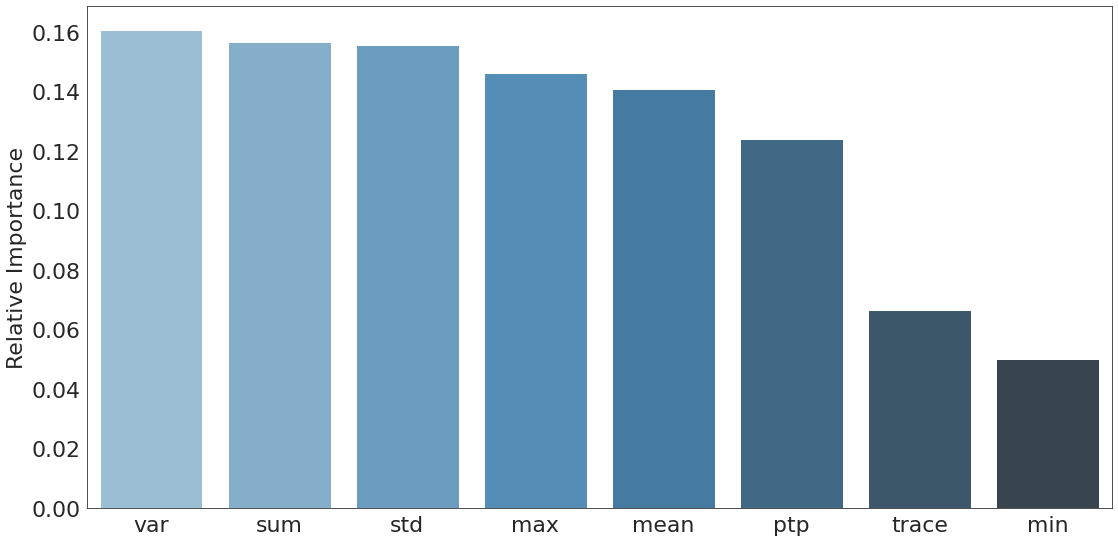

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features.drop('target', axis=1), features['target'], test_size=0.10, random_state=0)# fitting the model
model = RandomForestClassifier()
model.fit(X_train, y_train)# plotting feature importances
features_forest = features.drop('target', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

fig = plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 22})
sns.barplot(x=[features_forest[i] for i in indices], y=importances[indices], palette="Blues_d")
plt.xlabel(None)
plt.ylabel('Relative Importance')
plt.tight_layout()
plt.savefig('figures/feature_importances.pdf')



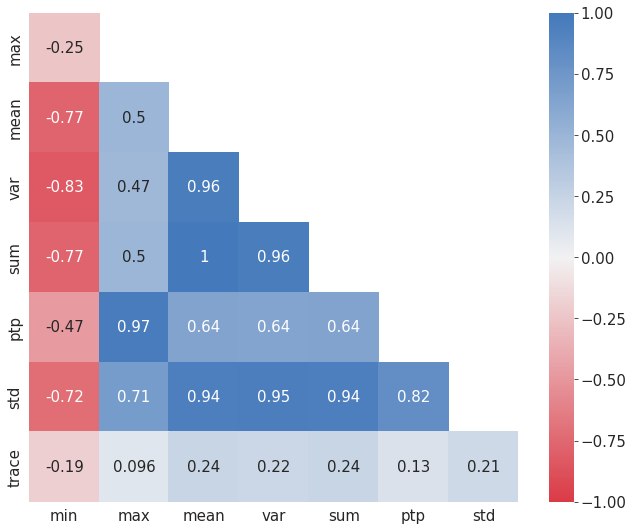

In [16]:
corr = features.drop('target', axis=1).corr().iloc[1: , :-1]
mask =  np.triu(np.ones_like(corr, dtype=np.bool), k=1)
sns.set_style(style = 'white')
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,
        square=True, vmin=-1, vmax=1, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), va="center")
plt.savefig('figures/feature_corr.pdf')

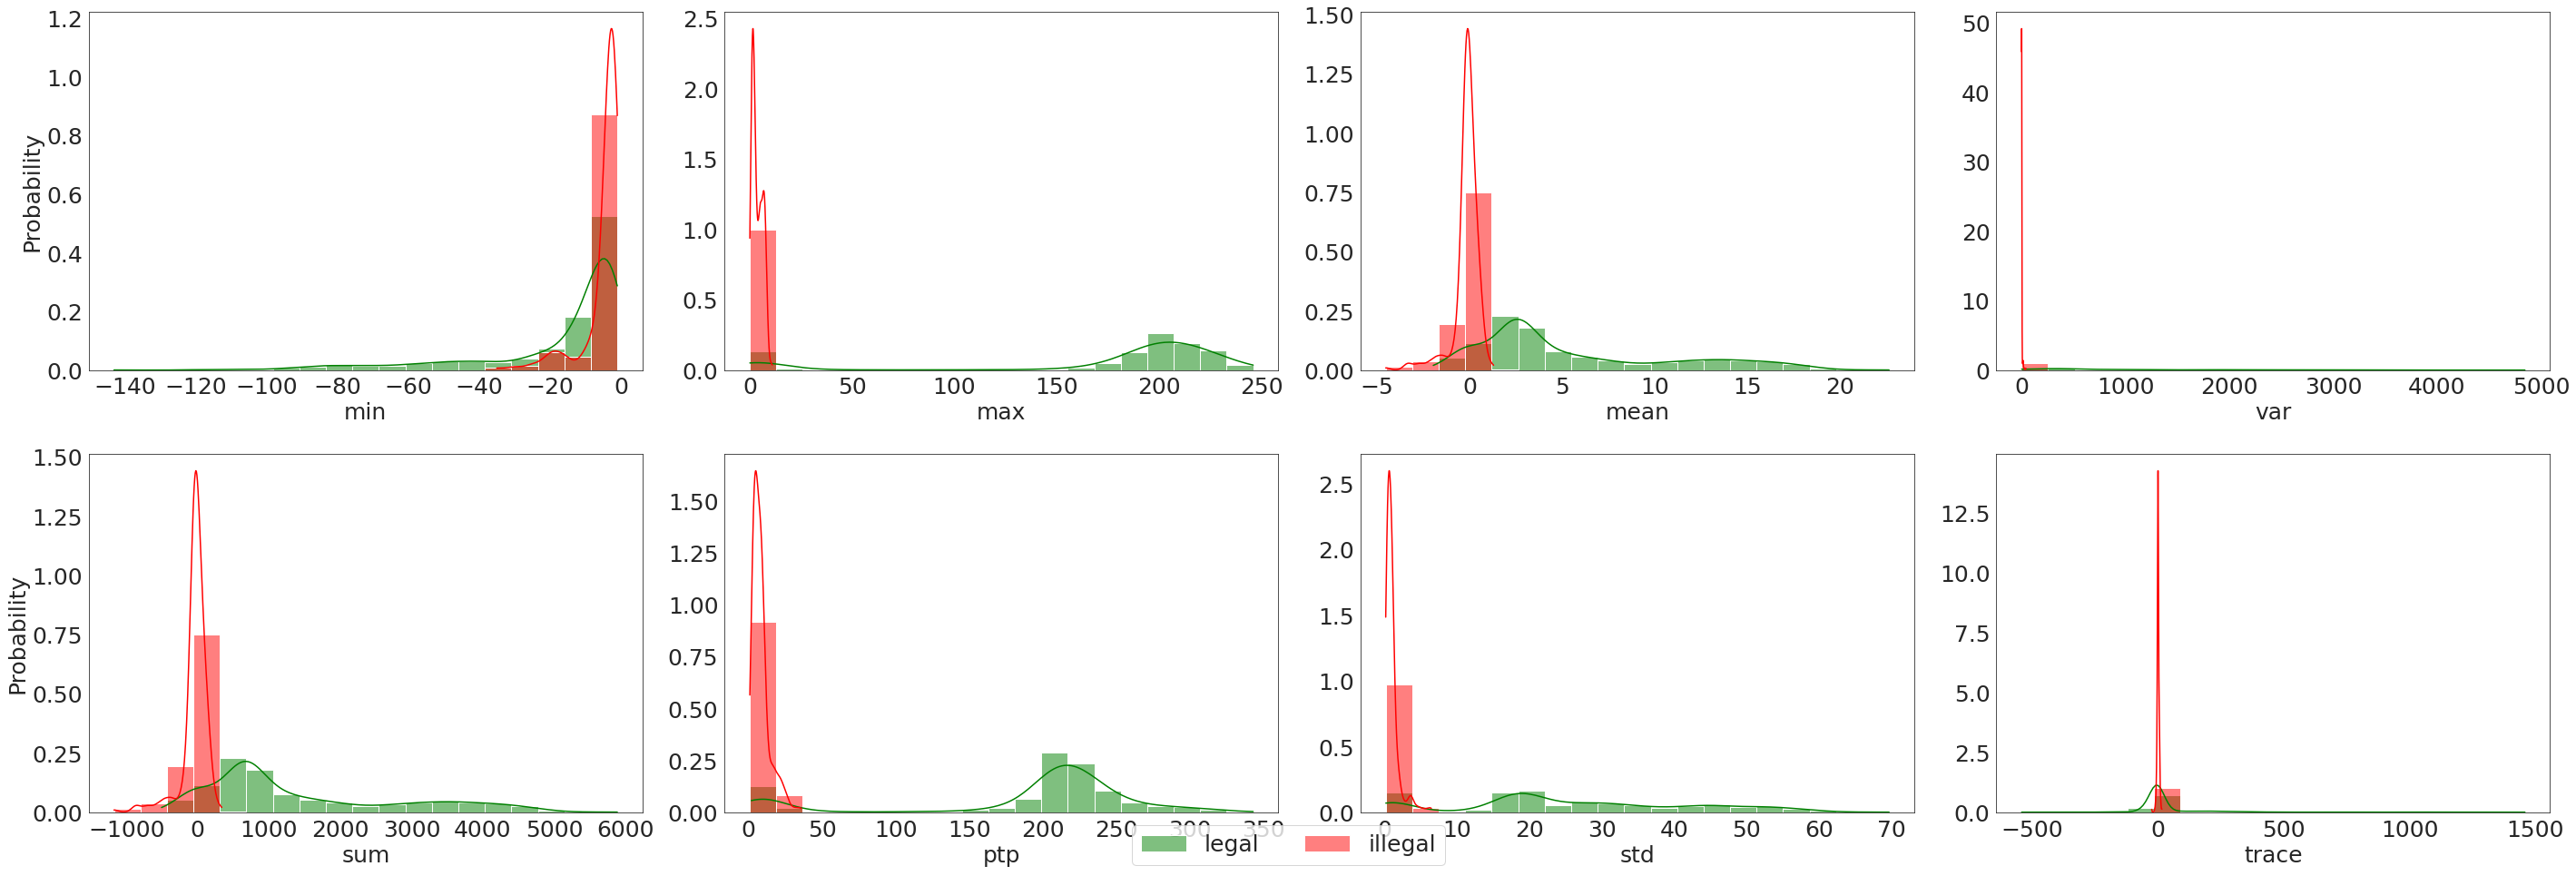

In [17]:


feature_types = features.columns[: features.columns.slice_locs(end='trace')[1]]
n_bins = 20
fig = plt.figure(figsize=(40, 14))
plt.rcParams.update({'font.size': 25})
sns.set_style(style = 'white')

i = 1
for feature in feature_types: # Cycle through columns until and including "trace"
    ax = plt.subplot(2, 4, i)
    bins = np.linspace(features[feature].min(), features[feature].max(), n_bins)
    # sns.histplot(data=touch_features, x=feature, kde=True, hue="target", bins=bins, stat="probability", color='g', label='legal')
    sns.histplot(data=touch_features, x=feature, kde=True, bins=bins, stat="probability", color='g', label='legal', ax=ax)
    sns.histplot(data=nontouch_features, x=feature, kde=True, bins=bins, stat="probability", color='r', label='illegal', ax=ax)

    if i % 4 != 1:
        plt.ylabel(None)
    i += 1
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2)
fig.tight_layout()
fig.subplots_adjust(top=0.95, bottom=0.075)
plt.savefig('figures/feature_distrib.pdf')

